In [1]:
#!pip install numpy --ignore-installed --user

In [2]:
import pandas as pd
import google.auth
from google.cloud import bigquery
import numpy as np
import pickle
#import gpflow
import datetime
import matplotlib.pyplot as plt
#from gpflow.utilities import print_summary
#import download_airnow_web
import pyproj
%matplotlib inline
#from paper_utils import *
from glob import glob
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

usecache = True

In [3]:
pathtofolders = 'data'

In [4]:
def processBAMdata():
    '''reading bam data
    '''
    metadf = pd.read_excel(pathtofolders+'/BAM Metadata.xlsx')
    print("Device Ids: ")
    print(metadf['Id'].unique())
    
    nakawabam = pd.read_csv(pathtofolders+'/nakawabam.csv')#Nakawa BAM
    nakawabam["channel_id"] = metadf['Id'].iloc[0]
    nakawabam["latitude"] = metadf['Latitude'].iloc[0]
    nakawabam["longitude"] = metadf['Longitude'].iloc[0]
    #print(nakawabam)
    
    mukbam = pd.read_csv(pathtofolders+'/mukbam.csv')#MUK BAM
    mukbam = pd.read_csv(pathtofolders+'/nakawabam.csv')#Nakawa BAM
    mukbam["channel_id"] = metadf['Id'].iloc[1]
    mukbam["latitude"] = metadf['Latitude'].iloc[1]
    mukbam["longitude"] = metadf['Longitude'].iloc[1]
    #print(mukbam)
       
    allbamdf = pd.concat([nakawabam, mukbam], ignore_index=True)
    allbamdf.rename(columns={'Time':'created_at','ConcHR(ug/m3)':'avg_pm'},inplace=True)
    allbamdf= allbamdf.drop(['ConcRT(ug/m3)','ConcS(ug/m3)', 'Flow(lpm)', 'WS(m/s)','WD(Deg)','AT(C)','RH(%)', 'BP(mmHg)',
                         'FT(C)','FRH(%)','Status'], axis=1)
#     allbamdf['created_at'] =  pd.to_datetime(all_data['created_at'], format='%d%b%Y:%H:%M:%S')
#     allbamdf['created_at'] = all_data['created_at'].dt.floor('T')
    
    embassydf = pd.read_csv(pathtofolders+'/Kampala_PM2.5_2020.csv') #US embassy BAM 
    embassydf['avg_pm'] = embassydf['Raw Conc.']
    embassydf['created_at'] = embassydf['Date (LT)']
    embassydf['channel_id']=1
    embassydf['latitude'] = 0.299333
    embassydf['longitude'] = 32.592539
#     embassydf['created_at'] =  pd.to_datetime(all_data['created_at'], format='%d%b%Y:%H:%M:%S')
#     embassydf['created_at'] = all_data['created_at'].dt.floor('T')
        
    allbamdata = pd.concat([allbamdf, embassydf], ignore_index=True)
    allbamdata = allbamdata.drop(['Site','Parameter', 'Date (LT)', 'Year','Month','Day','Hour','AQI', 'NowCast Conc.',
                                 'AQI Category','Raw Conc.', 'Conc. Unit','Duration', 'QC Name'], axis=1)
    allbamdata = allbamdata[allbamdata['avg_pm'] <= 500.4]
    allbamdata = allbamdata[allbamdata['avg_pm'] > 0]   
    return allbamdata

In [5]:
allbamdata = processBAMdata()
allbamdata['created_at'] =  pd.to_datetime(allbamdata['created_at'])
allbamdata['created_at'] = allbamdata['created_at'].dt.floor('H')
allbamdata.tail()

Device Ids: 
['Y24517' 'Y24516']


,created_at,avg_pm,channel_id,latitude,longitude
10082,2020-10-31 20:00:00,40.0,1,0.299333,32.592539
10083,2020-10-31 21:00:00,38.0,1,0.299333,32.592539
10084,2020-10-31 22:00:00,46.0,1,0.299333,32.592539
10085,2020-10-31 23:00:00,44.0,1,0.299333,32.592539
10086,2020-11-01 00:00:00,36.0,1,0.299333,32.592539


In [6]:
#client = bigquery.Client.from_service_account_json(bigquery_account_json)
client = bigquery.Client.from_service_account_json("airqo-250220-5149c2aac8f2.json")

In [7]:
def get_all_data():
    sql = """
SELECT 
    clean_feeds_pms.created_at,
    clean_feeds_pms.channel_id, 
    SUM(pm2_5 + s2_pm2_5)/2 as avg_pm,
    channel.name as Location,
    channel.latitude as latitude,
    channel.longitude as longitude
FROM 
    `airqo-250220.thingspeak.clean_feeds_pms` clean_feeds_pms
INNER JOIN 
    `airqo-250220.thingspeak.channel` channel ON clean_feeds_pms.channel_id = channel.channel_id
WHERE  
    clean_feeds_pms.created_at >="2020-08-05T00:00:00"
AND 
    clean_feeds_pms.created_at <="2020-08-06T23:59:59"
GROUP BY 
    clean_feeds_pms.created_at, channel.name,latitude,longitude,clean_feeds_pms.channel_id
ORDER BY 
    clean_feeds_pms.created_at
DESC
    """

    all_data = client.query(sql).to_dataframe()
    
    return  all_data

In [8]:
def get_mobile_data():
    sql = """
SELECT 
    created_at,
    channel_id, 
    SUM(pm2_5 + s2_pm2_5)/2 as avg_pm,
    latitude,
    longitude
FROM 
    `airqo-250220.thingspeak.clean_feeds_pms` clean_feeds_pms
WHERE  
    clean_feeds_pms.created_at >="2020-08-05T00:00:00"
AND 
    clean_feeds_pms.created_at <="2020-08-06T23:59:59"
AND 
    channel_id IN (930430, 930428, 930432, 930435)
GROUP BY 
    created_at, latitude, longitude, channel_id
ORDER BY 
    clean_feeds_pms.created_at
DESC
    """

    mobile_data = client.query(sql).to_dataframe()
    
    return  mobile_data

In [9]:
all_data = get_all_data()
all_data.tail()

,created_at,channel_id,avg_pm,Location,latitude,longitude
91316,2020-08-05 00:00:09,737278,42.765,AIRQO-WB40 UNIT ACTIVE,0.4007,32.0422
91317,2020-08-05 00:00:06,675801,6.550,AIRQO-WB6 UNIT ACTIVE,0.6939,34.1814
91318,2020-08-05 00:00:05,870139,146.530,AIRQO-56 UNIT ACTIVE,0.3101,32.5160
91319,2020-08-05 00:00:04,737276,76.405,AIRQO-WB39 UNIT ACTIVE,0.2953,32.5537
91320,2020-08-05 00:00:00,782722,69.800,AIRQO-49 UNIT ACTIVE,0.2836,32.6000


In [10]:
mobile_data = get_mobile_data()
mobile_data.head()

,created_at,channel_id,avg_pm,latitude,longitude
0,2020-08-06 17:06:09,930435,79.500,0.282264,32.595055
1,2020-08-06 17:05:40,930435,66.330,0.281934,32.595428
2,2020-08-06 17:04:35,930435,89.330,0.282470,32.597641
3,2020-08-06 17:04:07,930435,150.835,0.284407,32.597355
4,2020-08-06 17:03:41,930435,231.165,0.286206,32.596985


In [11]:
all_data['created_at'] =  pd.to_datetime(all_data['created_at'], format='%d%b%Y:%H:%M:%S')
all_data['created_at'] = all_data['created_at'].dt.floor('H')
all_data.head()

,created_at,channel_id,avg_pm,Location,latitude,longitude
0,2020-08-06 23:00:00,832254,44.925,AirQo-54 Unit Active,0.3564,34.0949
1,2020-08-06 23:00:00,870147,34.015,AIRQO-63 UNIT ACTIVE,0.3630,32.5290
2,2020-08-06 23:00:00,755612,47.315,AIRQO-43 UNIT ACTIVE,0.2890,32.5890
3,2020-08-06 23:00:00,870143,71.065,AIRQO-59 UNIT ACTIVE,0.3816,32.6471
4,2020-08-06 23:00:00,870139,49.115,AIRQO-56 UNIT ACTIVE,0.3101,32.5160


In [12]:
mobile_data['created_at'] =  pd.to_datetime(mobile_data['created_at'], format='%d%b%Y:%H:%M:%S')
mobile_data['created_at'] = mobile_data['created_at'].dt.floor('H')
mobile_data.tail()

,created_at,channel_id,avg_pm,latitude,longitude
4515,2020-08-05 02:00:00,930435,90.500,0.286389,32.596851
4516,2020-08-05 02:00:00,930435,108.335,0.286392,32.596844
4517,2020-08-05 02:00:00,930435,85.170,0.286395,32.596855
4518,2020-08-05 02:00:00,930435,103.670,0.286392,32.596851
4519,2020-08-05 02:00:00,930435,86.830,0.286385,32.596848


In [13]:
all_data = pd.concat([all_data, allbamdata], ignore_index=True)
all_data

,created_at,channel_id,avg_pm,Location,latitude,longitude
0,2020-08-06 23:00:00,832254,44.925,AirQo-54 Unit Active,0.356400,34.094900
1,2020-08-06 23:00:00,870147,34.015,AIRQO-63 UNIT ACTIVE,0.363000,32.529000
2,2020-08-06 23:00:00,755612,47.315,AIRQO-43 UNIT ACTIVE,0.289000,32.589000
3,2020-08-06 23:00:00,870143,71.065,AIRQO-59 UNIT ACTIVE,0.381600,32.647100
4,2020-08-06 23:00:00,870139,49.115,AIRQO-56 UNIT ACTIVE,0.310100,32.516000
...,...,...,...,...,...,...
101324,2020-10-31 20:00:00,1,40.000,NaN,0.299333,32.592539
101325,2020-10-31 21:00:00,1,38.000,NaN,0.299333,32.592539
101326,2020-10-31 22:00:00,1,46.000,NaN,0.299333,32.592539
101327,2020-10-31 23:00:00,1,44.000,NaN,0.299333,32.592539


In [14]:
from sklearn.neighbors import DistanceMetric
from math import radians, cos, sin, asin, sqrt
# import sklearn.neighbors

In [15]:
# add columns with radians for latitude and longitude
all_data[['lat_radians_A','long_radians_A']] = (
    np.radians(all_data.loc[:,['latitude','longitude']])
)
mobile_data[['lat_radians_B','long_radians_B']] = (
    np.radians(mobile_data.loc[:,['latitude','longitude']])
)
all_data

,created_at,channel_id,avg_pm,Location,latitude,longitude,lat_radians_A,long_radians_A
0,2020-08-06 23:00:00,832254,44.925,AirQo-54 Unit Active,0.356400,34.094900,0.006220,0.595068
1,2020-08-06 23:00:00,870147,34.015,AIRQO-63 UNIT ACTIVE,0.363000,32.529000,0.006336,0.567738
2,2020-08-06 23:00:00,755612,47.315,AIRQO-43 UNIT ACTIVE,0.289000,32.589000,0.005044,0.568785
3,2020-08-06 23:00:00,870143,71.065,AIRQO-59 UNIT ACTIVE,0.381600,32.647100,0.006660,0.569799
4,2020-08-06 23:00:00,870139,49.115,AIRQO-56 UNIT ACTIVE,0.310100,32.516000,0.005412,0.567511
...,...,...,...,...,...,...,...,...
101324,2020-10-31 20:00:00,1,40.000,NaN,0.299333,32.592539,0.005224,0.568847
101325,2020-10-31 21:00:00,1,38.000,NaN,0.299333,32.592539,0.005224,0.568847
101326,2020-10-31 22:00:00,1,46.000,NaN,0.299333,32.592539,0.005224,0.568847
101327,2020-10-31 23:00:00,1,44.000,NaN,0.299333,32.592539,0.005224,0.568847


In [16]:
result = pd.merge(all_data, mobile_data, on=['created_at'])
result

,created_at,channel_id_x,avg_pm_x,Location,latitude_x,longitude_x,lat_radians_A,long_radians_A,channel_id_y,avg_pm_y,latitude_y,longitude_y,lat_radians_B,long_radians_B
0,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,79.500,0.282264,32.595055,0.004926,0.568891
1,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,66.330,0.281934,32.595428,0.004921,0.568898
2,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,89.330,0.282470,32.597641,0.004930,0.568936
3,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,150.835,0.284407,32.597355,0.004964,0.568931
4,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,231.165,0.286206,32.596985,0.004995,0.568925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9206337,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,90.500,0.286389,32.596851,0.004998,0.568922
9206338,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,108.335,0.286392,32.596844,0.004998,0.568922
9206339,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,85.170,0.286395,32.596855,0.004999,0.568922
9206340,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,103.670,0.286392,32.596851,0.004998,0.568922


In [17]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km 

In [18]:
# for index, row in result.iterrows():
#     result.loc[index, 'distance'] = haversine(row['longitude_x'], row['latitude_x'], row['longitude_y'], row['latitude_x'])
result['distance'] = haversine_np(result['longitude_x'],result['latitude_x'],result['longitude_y'],result['latitude_x'])

In [19]:
result

,created_at,channel_id_x,avg_pm_x,Location,latitude_x,longitude_x,lat_radians_A,long_radians_A,channel_id_y,avg_pm_y,latitude_y,longitude_y,lat_radians_B,long_radians_B,distance
0,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,79.500,0.282264,32.595055,0.004926,0.568891,92.660775
1,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,66.330,0.281934,32.595428,0.004921,0.568898,92.702224
2,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,89.330,0.282470,32.597641,0.004930,0.568936,92.948140
3,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,150.835,0.284407,32.597355,0.004964,0.568931,92.916358
4,2020-08-06 17:00:00,675851,75.65,AIRQO-WB8 UNIT ACTIVE,-0.321300,31.761200,-0.005608,0.554338,930435,231.165,0.286206,32.596985,0.004995,0.568925,92.875243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9206337,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,90.500,0.286389,32.596851,0.004998,0.568922,0.479165
9206338,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,108.335,0.286392,32.596844,0.004998,0.568922,0.478387
9206339,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,85.170,0.286395,32.596855,0.004999,0.568922,0.479609
9206340,2020-08-05 02:00:00,1,81.00,NaN,0.299333,32.592539,0.005224,0.568847,930435,103.670,0.286392,32.596851,0.004998,0.568922,0.479165


In [20]:
result = result[(result['distance'] <= 0.02)]
result

,created_at,channel_id_x,avg_pm_x,Location,latitude_x,longitude_x,lat_radians_A,long_radians_A,channel_id_y,avg_pm_y,latitude_y,longitude_y,lat_radians_B,long_radians_B,distance
19909,2020-08-06 16:00:00,782720,114.155,AIRQO-47 UNIT ACTIVE,0.351700,32.591000,0.006138,0.568820,930428,73.500,0.365649,32.590965,0.006382,0.568820,0.003889
20657,2020-08-06 16:00:00,782722,101.365,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,89.500,0.272942,32.600029,0.004764,0.568978,0.003223
20658,2020-08-06 16:00:00,782722,101.365,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,95.000,0.272959,32.600037,0.004764,0.568978,0.004112
20905,2020-08-06 16:00:00,930434,137.360,AIRQO-79 UNIT ACTIVE,0.360209,32.610756,0.006287,0.569165,930428,69.335,0.365883,32.610832,0.006386,0.569166,0.008445
23536,2020-08-06 16:00:00,782720,111.105,AIRQO-47 UNIT ACTIVE,0.351700,32.591000,0.006138,0.568820,930428,73.500,0.365649,32.590965,0.006382,0.568820,0.003889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9170771,2020-08-05 03:00:00,782722,99.515,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,82.165,0.294674,32.600052,0.005143,0.568978,0.005778
9174715,2020-08-05 03:00:00,782722,100.390,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,125.000,0.294515,32.600048,0.005140,0.568978,0.005334
9174730,2020-08-05 03:00:00,782722,100.390,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,82.165,0.294674,32.600052,0.005143,0.568978,0.005778
9179209,2020-08-05 03:00:00,782722,100.510,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,125.000,0.294515,32.600048,0.005140,0.568978,0.005334


In [21]:
#do this for every channel id and find mean ratio
result['logratio'] = np.log(result['avg_pm_y']/result['avg_pm_x'])
result 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,created_at,channel_id_x,avg_pm_x,Location,latitude_x,longitude_x,lat_radians_A,long_radians_A,channel_id_y,avg_pm_y,latitude_y,longitude_y,lat_radians_B,long_radians_B,distance,logratio
19909,2020-08-06 16:00:00,782720,114.155,AIRQO-47 UNIT ACTIVE,0.351700,32.591000,0.006138,0.568820,930428,73.500,0.365649,32.590965,0.006382,0.568820,0.003889,-0.440272
20657,2020-08-06 16:00:00,782722,101.365,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,89.500,0.272942,32.600029,0.004764,0.568978,0.003223,-0.124489
20658,2020-08-06 16:00:00,782722,101.365,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,95.000,0.272959,32.600037,0.004764,0.568978,0.004112,-0.064851
20905,2020-08-06 16:00:00,930434,137.360,AIRQO-79 UNIT ACTIVE,0.360209,32.610756,0.006287,0.569165,930428,69.335,0.365883,32.610832,0.006386,0.569166,0.008445,-0.683655
23536,2020-08-06 16:00:00,782720,111.105,AIRQO-47 UNIT ACTIVE,0.351700,32.591000,0.006138,0.568820,930428,73.500,0.365649,32.590965,0.006382,0.568820,0.003889,-0.413190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9170771,2020-08-05 03:00:00,782722,99.515,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,82.165,0.294674,32.600052,0.005143,0.568978,0.005778,-0.191579
9174715,2020-08-05 03:00:00,782722,100.390,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,125.000,0.294515,32.600048,0.005140,0.568978,0.005334,0.219251
9174730,2020-08-05 03:00:00,782722,100.390,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,82.165,0.294674,32.600052,0.005143,0.568978,0.005778,-0.200333
9179209,2020-08-05 03:00:00,782722,100.510,AIRQO-49 UNIT ACTIVE,0.283600,32.600000,0.004950,0.568977,930435,125.000,0.294515,32.600048,0.005140,0.568978,0.005334,0.218057


In [22]:
import networkx as nx
from scipy.optimize import curve_fit
from pylab import rcParams
import seaborn as sb

In [23]:
rcParams['figure.figsize'] = 12, 8
sb.set_style('whitegrid')

In [36]:
ref = 1

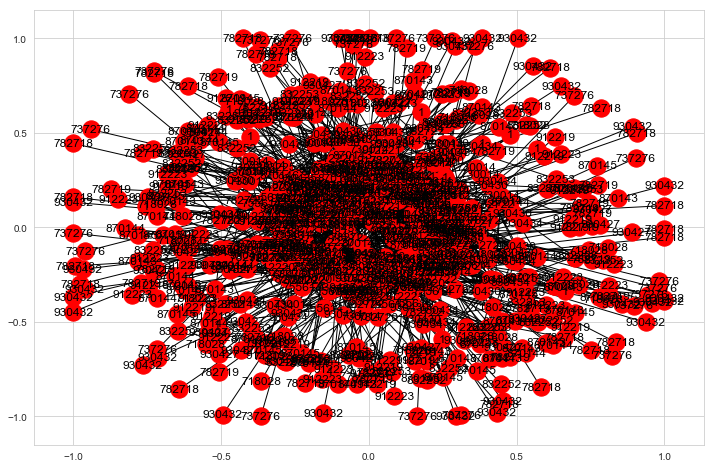

In [37]:
sps = []
for cat in result['created_at'].unique(): 
    G = nx.from_pandas_edgelist(result, 'channel_id_x', 'channel_id_y')#, edge_attr='logratio'
    sp = nx.shortest_paths.single_source_dijkstra_path(G,ref)
    sps.append(sp)
    nx.draw_networkx(G,pos=nx.spring_layout(G))
#     plt.savefig('plotgraph.png', dpi=300, bbox_inches='tight')
#     plt.show()

In [25]:
sps

[{1: [1],
  930430: [1, 930430],
  930435: [1, 930435],
  730014: [1, 930430, 730014],
  832253: [1, 930430, 832253],
  782718: [1, 930430, 782718],
  737276: [1, 930430, 737276],
  870146: [1, 930430, 870146],
  912221: [1, 930430, 912221],
  689761: [1, 930430, 689761],
  755612: [1, 930430, 755612],
  912220: [1, 930430, 912220],
  782721: [1, 930430, 782721],
  930431: [1, 930430, 930431],
  782722: [1, 930435, 782722],
  755614: [1, 930435, 755614],
  930434: [1, 930435, 930434],
  782719: [1, 930435, 782719],
  782720: [1, 930435, 782720],
  930428: [1, 930430, 730014, 930428],
  930432: [1, 930435, 930434, 930432],
  870145: [1, 930430, 730014, 930428, 870145],
  912219: [1, 930430, 730014, 930428, 912219],
  912223: [1, 930430, 730014, 930428, 912223],
  870144: [1, 930430, 730014, 930428, 870144],
  870143: [1, 930430, 730014, 930428, 870143],
  832252: [1, 930430, 730014, 930428, 832252],
  718028: [1, 930430, 730014, 930428, 718028],
  930427: [1, 930430, 730014, 930428, 930